## M1 [KTL]: REFIT House 2 to REFIT House 2

### Reference paper:
 * A. M. A. Ahmed, Y. Zhang and F. Eliassen, "Generative Adversarial Networks and Transfer Learning for Non-Intrusive Load Monitoring in Smart Grids," 2020 IEEE International Conference on Communications, Control, and Computing Technologies for Smart Grids (SmartGridComm), Tempe, AZ, USA, 2020, pp. 1-7, doi: 10.1109/SmartGridComm47815.2020.9302933.

### Importing packages

In [69]:
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler as standarize_data
from sklearn.preprocessing import MinMaxScaler as scale_data
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, zero_one_loss,mean_absolute_error,r2_score  
plt.style.use('bmh')


### parameters and configuration

In [70]:
lr=0.000001  #0.00002   0.000001
b1=0.5
b2=0.999
n_epochs=6000
batch_size=128 #1024
s=2
sample_interval=500

cuda = True if torch.cuda.is_available() else False

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

cuda



True

## loading, downsampling and scaling data

In [71]:
import pandas as pd
def dataProvider(train, windowsize):
    
    data_frame = pd.read_csv(train,
                             #chunksize=10 ** 3,
                             header=0
                             )
    np_array = np.array(data_frame)
    X_to_disaggregate, Y_true = np_array[:, 0], np_array[:, 1]
    agg_len=X_to_disaggregate.shape[0]
    w=windowsize
    step=int(15)
    agg_segments=np.zeros((1,w))
    app_segments=np.zeros((1,w))
    i=0
    while i<=agg_len-w:
        agg_segment=X_to_disaggregate[i:i+w].reshape(1,-1)
        app_segment=Y_true[i:i+w].reshape(1,-1)
        agg_segments=np.concatenate((agg_segments,agg_segment),axis=0)
        app_segments=np.concatenate((app_segments,app_segment),axis=0)
        i+=step

    agg_segments=agg_segments[1:,:]    
    app_segments=app_segments[1:,:]
    return agg_segments, app_segments


In [72]:
trainfile1 = "F:/NILM/training_data/fridge_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/fridge_house_3_training_.csv"
testfile="F:/NILM/training_data/fridge_test_.csv"
X1,Y1=dataProvider(testfile,39)
X2,Y2=dataProvider(trainfile1,39)
X3,Y3=dataProvider(trainfile2,39)
X=np.concatenate((X1,X2,X3),axis=0)
Y=np.concatenate((Y1,Y2,Y3),axis=0)
print(X.shape)
print(Y.shape)

(35379, 39)
(35379, 39)


In [73]:
# loading the signature and aggregate measurement

# # apply a threshold of 50
# X_train[X_train<=50] = 0
# Y_train[Y_train<=50] = 0
n_train=int(0.8*len(X))
X_train=X[:n_train]
X_test=X[n_train:]
Y_train = Y[:n_train]
Y_test= Y[n_train:]
# Scaling data
scale_agg=scale_data()
scale_app=scale_data()

scale_agg_test=scale_data()
scale_app_test=scale_data()

scale_agg.fit(X_train)
scale_app.fit(Y_train)

# Transforming trainig data

X_train_n=scale_agg.transform(X_train)
Y_train_n=scale_app.transform(Y_train)

X_train_n.shape

(28303, 39)

(39,)


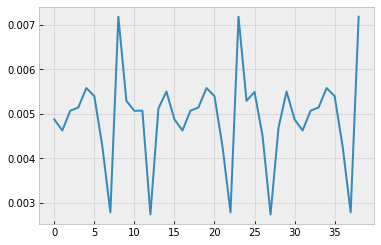

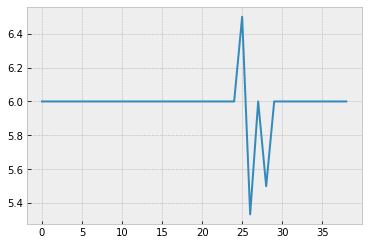

In [74]:
print(Y_train_n[0,:].shape)
import matplotlib.pyplot as plt
plt.plot(Y_train_n[0,:])
plt.show()

true_app_inv=scale_app.inverse_transform(Y_train_n)
plt.plot(true_app_inv[0,:])
plt.show()

In [75]:
a=scale_app.inverse_transform(Y_train_n)[0,:].reshape(1,-1)
scale_app.transform(a)

array([[0.00487805, 0.00462963, 0.005074  , 0.0051458 , 0.00558399,
        0.00540054, 0.00427046, 0.0027881 , 0.00718563, 0.00529568,
        0.00507185, 0.005074  , 0.00274223, 0.00512383, 0.00550459,
        0.00487805, 0.00462963, 0.005074  , 0.0051458 , 0.00558399,
        0.00540054, 0.00427046, 0.0027881 , 0.00718563, 0.00529568,
        0.00549451, 0.00451022, 0.00274223, 0.00469684, 0.00550459,
        0.00487805, 0.00462963, 0.005074  , 0.0051458 , 0.00558399,
        0.00540054, 0.00427046, 0.0027881 , 0.00718563]])

In [76]:
a=np.array([1,2,3,4,5]).reshape(1,-1)
scale=scale_data()
scale.fit(a)
b=scale.transform(a)
scale.inverse_transform(b)

array([[1., 2., 3., 4., 5.]])

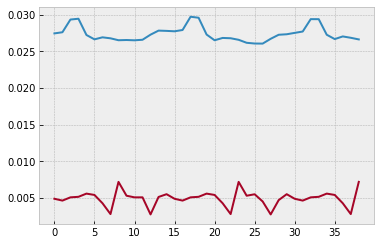

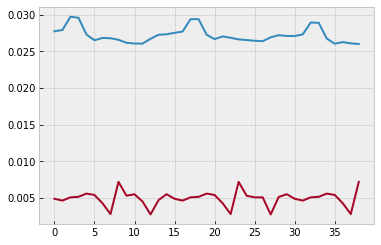

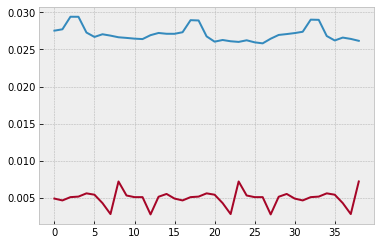

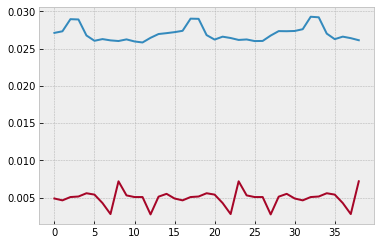

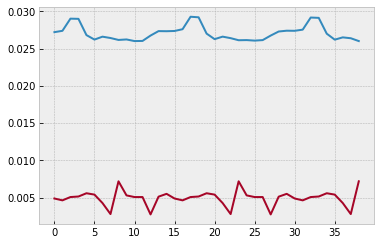

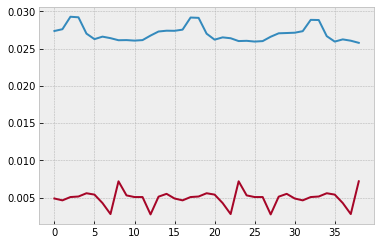

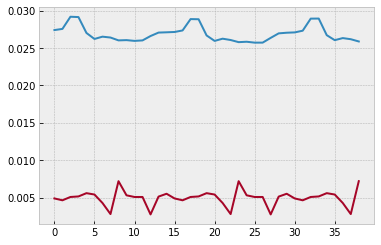

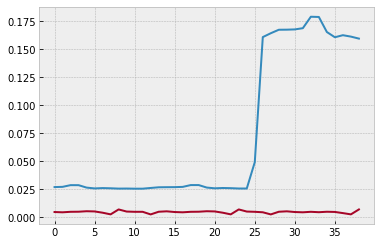

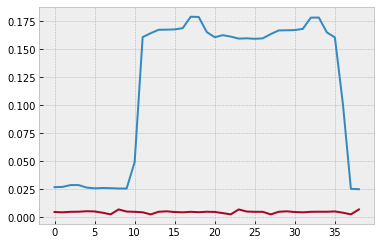

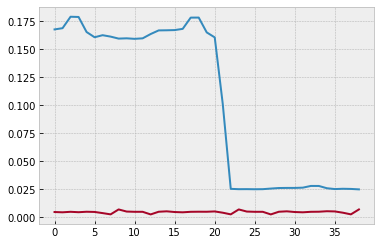

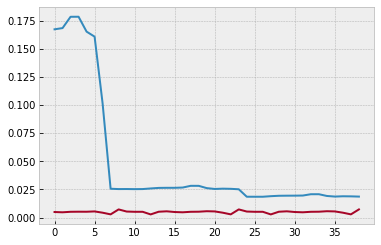

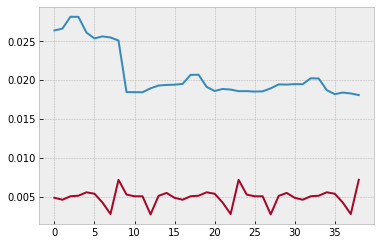

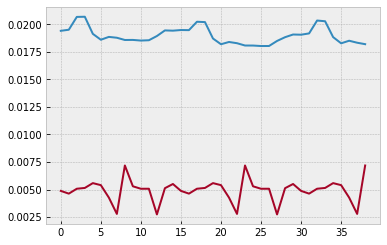

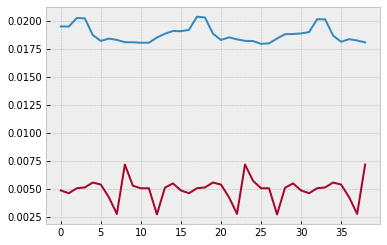

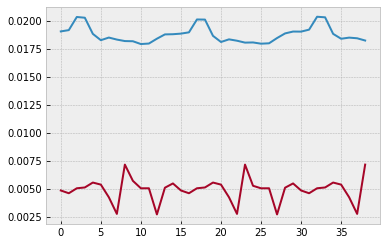

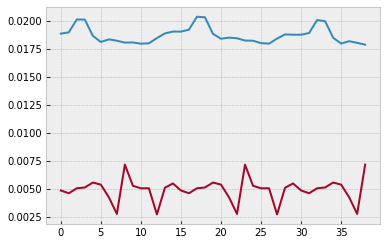

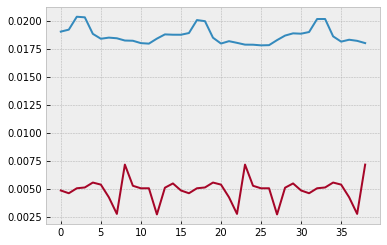

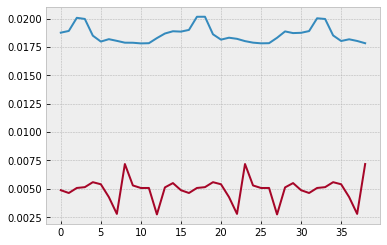

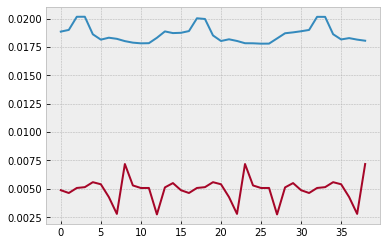

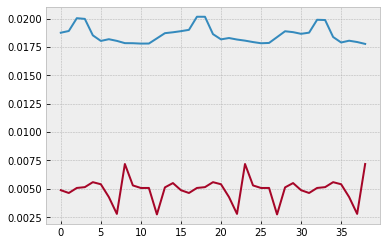

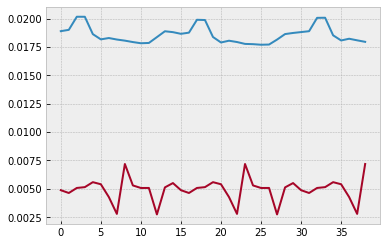

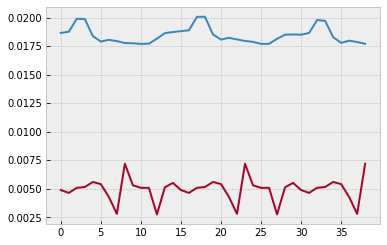

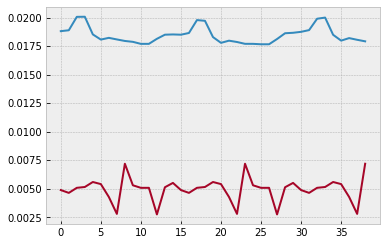

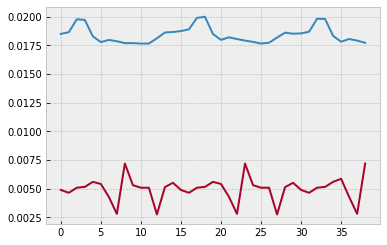

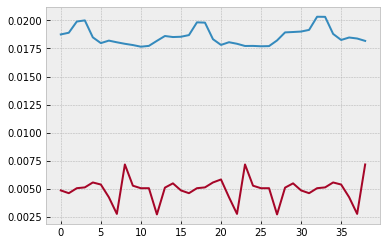

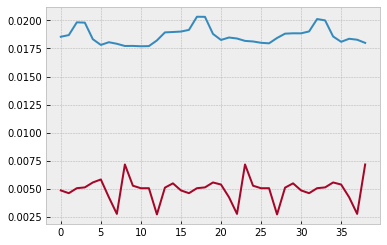

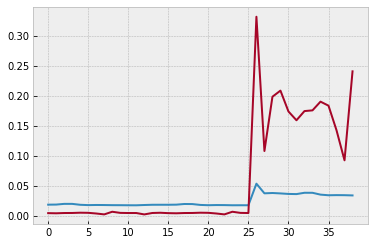

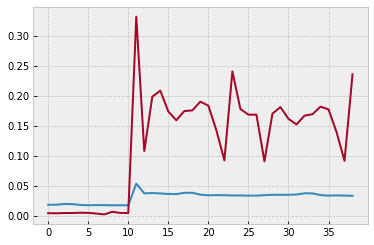

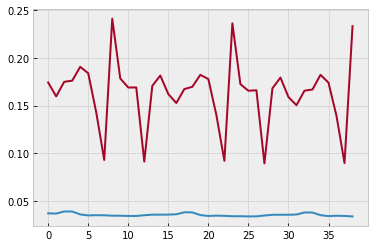

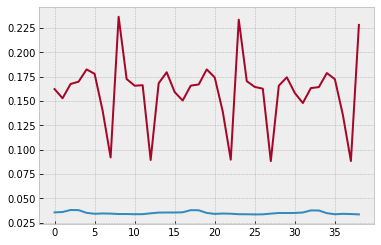

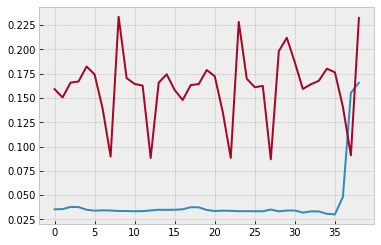

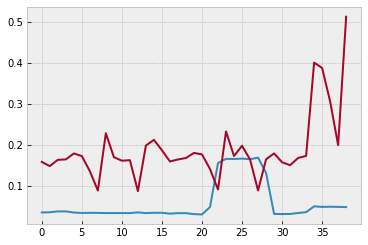

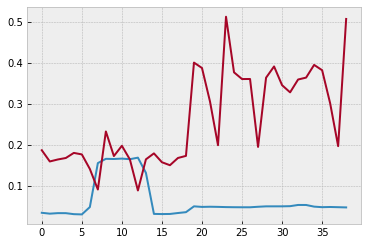

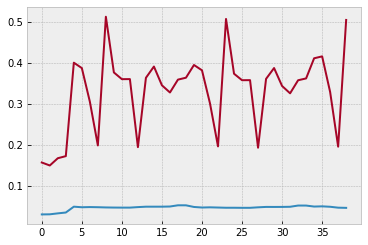

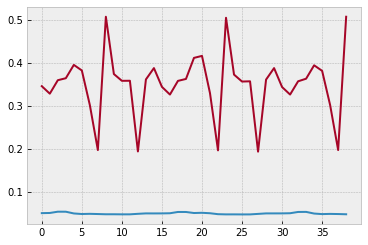

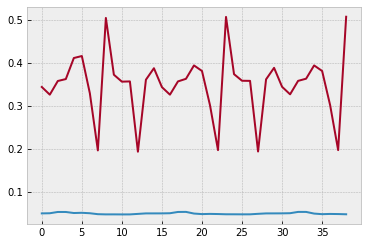

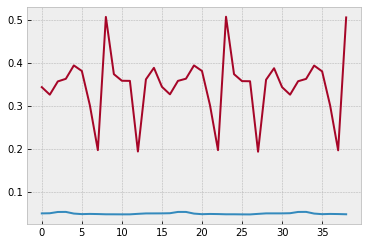

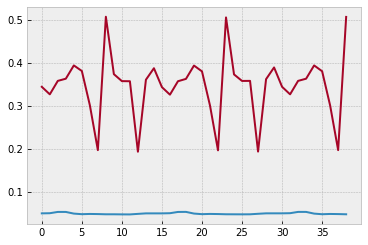

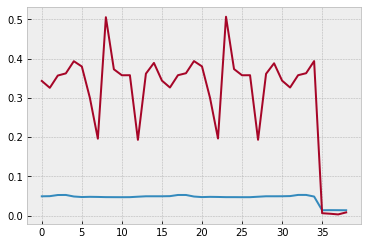

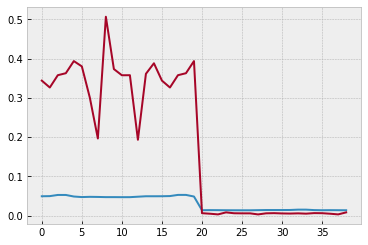

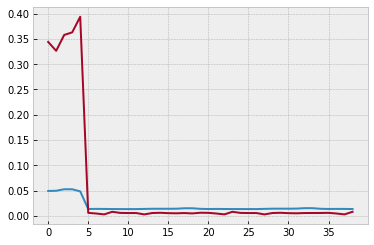

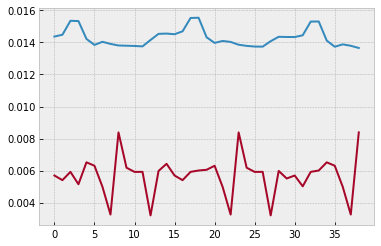

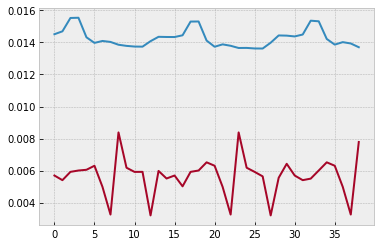

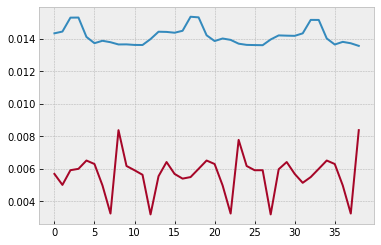

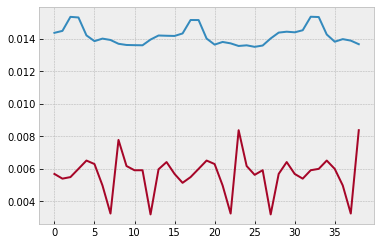

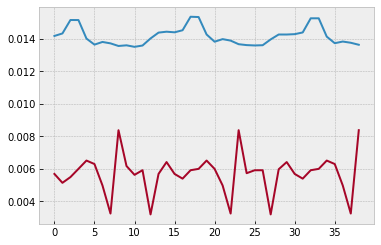

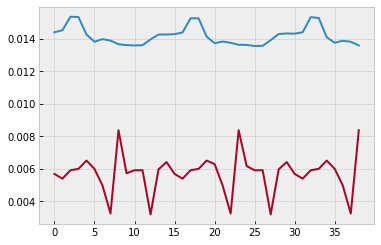

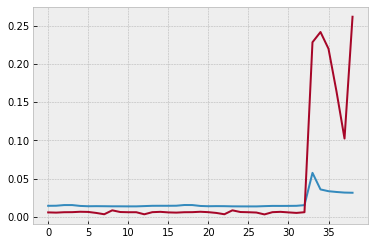

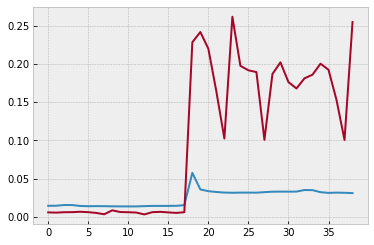

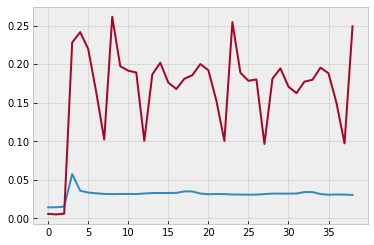

(28303, 39)

In [77]:
# Uncomment those lines to plot some examples
for i in range(50):
    plt.plot(X_train_n[i,:])
    plt.plot(Y_train_n[i,:])
    plt.show()
X_train.shape

## GANNILM Classes

In [78]:
sig_len=39
class Swish(torch.nn.Module):
    def forward(self,x):
        return x * torch.sigmoid(x)


class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

    
class Projection(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size,projection,-1) #bsize, projection,length


    
class Generator(nn.Module):
    def __init__(self):
        super().__init__()


        def block(in_feat, out_feat, normalize=False):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.9))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        def conv(in_feat, out_feat, filter_size=5, stride=1,padding=True):
            if padding==True: 
                p=int((filter_size-1)/2)
            else:
                p=0
            conv_layers = [nn.Conv1d(in_feat, out_feat,filter_size,stride,padding=p)]
            conv_layers.append(nn.LeakyReLU(0.2, inplace=True))
            return conv_layers

        def flat():
            flatten=Flatten()
            layers = [flatten]
            #layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        def swish():
            s=Swish()
            layers = [s]
            return layers
        
        def project():
            project_layer=Projection()
            layers = [project_layer]
            return layers
        
        
        f=8#output featrue maps
        
        self.g1 = nn.Sequential(
            *conv(in_feat=1,out_feat=f*2,filter_size=5,stride=1,padding=True),
            

        )
        
        self.g2 = nn.Sequential(
            *conv(in_feat=f*2,out_feat=f*3,filter_size=5,stride=1,padding=True),
            *flat(),
        )
        
        self.g3 = nn.Sequential(
            *block(sig_len*f*3, int(sig_len*f*4), normalize=False),

        )
        
        
        self.g4 = nn.Sequential(
            *block(int(sig_len*f*4), int(sig_len*f*6)),

        )
        
        
        
        
        self.g5 = nn.Sequential(
            
            *block(int(sig_len*f*6), int(sig_len*f*4)),

        )
        
         
        self.g6 = nn.Sequential(
            
            *block(int(sig_len*f*4), int(sig_len*f*3)),

        )
        
        self.g7 = nn.Sequential(
            
            nn.Linear(int(sig_len*f*3), int(np.prod(sig_len))),
            nn.LeakyReLU(0.01, inplace=True) #tanh
        )

    #def forward(self, noise, labels):
    def forward(self,aggregate):
        X = self.g1(aggregate)
        X = self.g2(X)
        X = self.g3(X)
        X = self.g4(X)
        X = self.g5(X)
        X = self.g6(X)
        appliance = self.g7(X)
        return appliance

In [79]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()


        d=4
        
        def conv(in_feat, out_feat, filter_size=5, stride=1,padding=True):
            if padding==True: 
                p=int((filter_size-1)/2)
            else:
                p=0
            conv_layers = [nn.Conv1d(in_feat, out_feat,filter_size,stride,padding=p)]
            conv_layers.append(nn.LeakyReLU(0.2, inplace=True))
            return conv_layers
        
        def flat():
            flatten=Flatten()
            layers = [flatten]
            return layers
        
        self.d1 = nn.Sequential(
            nn.Linear(int(sig_len*2), sig_len*d),
            nn.LeakyReLU(0.2, inplace=True),
            
            
        )
        
        self.d2 = nn.Sequential(
            nn.Linear(sig_len*d, sig_len*d),
            nn.LeakyReLU(0.2, inplace=True),
 
            
        )
        
        self.d3 = nn.Sequential(
            
            nn.Linear(sig_len*d, sig_len*d),
            nn.LeakyReLU(0.2, inplace=True),
            
            
        )
        
        self.d4 = nn.Sequential(

            nn.Linear(sig_len*d, sig_len*2),
            nn.LeakyReLU(0.2, inplace=True),
            
        )
        
        
        self.d5 = nn.Sequential(
            
            nn.Linear(sig_len*2, 1),
            nn.Sigmoid(),

        )
        
        

    def forward(self, d_input):
        X=self.d1(d_input)
        X=self.d2(X)
        X=self.d3(X)
        features=self.d4(X)
        validity = self.d5(features)
        
        return validity,features


In [80]:
class DataIterator(Dataset):
    def __init__(self):

        self.len=X_train_n.shape[0]
        self.xdata=torch.from_numpy(X_train_n)
        self.ydata=torch.from_numpy(Y_train_n)
        
    def __getitem__(self,index):
        return (self.xdata[index],self.ydata[index])
    
    def __len__(self):
        return(self.len)


## Loss Definition and instantiation

In [81]:
feature_loss=torch.nn.MSELoss()
# adversarial_loss = torch.nn.MSELoss()
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()



## Loading Model

In [82]:
#uncomment those lines when loading a trained model
# PATH="gannilm_refit.pth"
# # PATH="gannilm_UKDALE.pth"
# checkpoint = torch.load(PATH)
# # generator.load_state_dict(checkpoint['g_state_dict'],strict=True)
# # discriminator.load_state_dict(checkpoint['d_state_dict'],strict=True)

## Utility Functions

In [83]:

def smooth(y, box_pts=2):
#     print("smooth in",y.shape)
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
#     print("smooth out",y_smooth.shape)
    return y_smooth


def down_sample(X,Y,s):
    #X=X.reshape(X.shape[0],X.shape[1])
    Y=Y.reshape(Y.shape[0],Y.shape[1])
    Y_s=Y[:, ::s]
    X_s=X[:,::s]
    dim=X_s.shape[1]
    return(X_s,Y_s.reshape(-1,dim))


def sample_data(n_row, batches_done):

    
#     a_to_s=X_train_n[0:10,:] # z
    a_to_s=X_train_n
    agg_to_sample=a_to_s.reshape(a_to_s.shape[0],1,a_to_s.shape[1])
    
    #true_app=Y_train_n[0:10,:]
    true_app=Y_train_n
 
    agg_to_sample = Variable(FloatTensor(agg_to_sample))
    gen_ds = generator(agg_to_sample)
    

    
    gen_ds_inv=scale_app.inverse_transform(gen_ds.cpu().detach())
    true_app_inv=scale_app.inverse_transform(true_app)
 
    
 

    plt.plot(smooth(gen_ds_inv[1000,:]),label="GAN")
    plt.plot(smooth(true_app_inv[1000,:]),label="Real")
    plt.legend()
    plt.show()

#     plt.plot(smooth(gen_ds_inv[5,:]),label="GAN")
#     plt.plot(true_app_inv[5,:],label="real")
#     plt.legend()
#     plt.show()


    
    

def disaggregate(x):
    x = Variable(FloatTensor(x))
    gen_appliance = generator(x)
    return (gen_appliance)

def confidence(appliance,aggregate):
    agg=Variable(FloatTensor(aggregate))
    d_in=torch.cat((appliance,agg),1)
    conf,_=discriminator(d_in)
    return(conf)


   
def classification_metrics(pred1, real_measurements1,thresh):
#    real_measurements
#    pred=predictions
    
    pred=np.copy(pred1)
    real_measurements=np.copy(real_measurements1)
    on_threshold=thresh
    pred[pred <=on_threshold] = 0
    pred[pred >on_threshold] = 1
    
    
    real_measurements[real_measurements <=on_threshold] = 0
    real_measurements[real_measurements >on_threshold] = 1

    TP=np.sum(np.logical_and(pred == 1, real_measurements == 1))
    FP=np.sum(np.logical_and(pred == 1, real_measurements == 0))

    FN=np.sum(np.logical_and(pred == 0, real_measurements == 1))
    TN=np.sum(np.logical_and(pred == 0, real_measurements == 0))
    P=sum(real_measurements)
    N=len(real_measurements)-sum(real_measurements)
    
    recall=TP/(TP+FN)
    precision=TP/(TP+FP)
    F1=2*(precision*recall)/(precision+recall)
    accuracy=(TP+TN)/(P+N)
    
    return(recall,precision,F1,accuracy)
    
    
    

def energy_metrics(pred1, real_measurements1,thresh):
    
    
    pred=np.copy(pred1)
    real_measurements=np.copy(real_measurements1)
    on_threshold=thresh
    pred[pred <=on_threshold] = 0
    real_measurements[real_measurements <=on_threshold] = 0

    
    E=np.sum(real_measurements)
    E_hat=np.sum(pred)
    RE=(E_hat-E)/(max(E,E_hat))
#     RE=(E_hat-E)/(E)
    T=len(pred)
    MAE=(1/T)*sum(np.abs(pred-real_measurements))
    return(RE,MAE)






## TL configuring

In [84]:


train_it=DataIterator()
dataloader=DataLoader(dataset=train_it,batch_size=batch_size,shuffle=True)



# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

g_losses=[]
d_losses=[]



for epoch in range(n_epochs):
    g_running_loss=0.0
    d_running_loss=0.0
    for i, (aggregate, appliance) in enumerate(dataloader):

        #reshaping to fit the convolution layer
        aggregate_reshaped=aggregate.reshape(aggregate.shape[0],1,aggregate.shape[1])

        batch_size = appliance.shape[0]
        app=appliance[:,:]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_aggregate_reshaped = Variable(aggregate_reshaped.type(FloatTensor))
        real_appliance = Variable(app.type(FloatTensor))
        real_aggregate= Variable(aggregate.type(FloatTensor))

        real_app_real_agg=torch.cat((real_appliance,real_aggregate),1)


        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()


        gen_appliance = generator(real_aggregate_reshaped)




        gen_app_real_agg=torch.cat((gen_appliance,real_aggregate),1)

        validity,feat= discriminator(gen_app_real_agg)

        g_loss=feature_loss(feat, real_app_real_agg)
#         g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()
        g_loss_1=g_loss.item()



########################################################################################################################
# # Generator second training round


        optimizer_G.zero_grad()

        gen_appliance = generator(real_aggregate_reshaped)



#         gen_appliance=gen_appliance-first_gen #subtract




        gen_app_real_agg=torch.cat((gen_appliance,real_aggregate),1)
        validity,feat = discriminator(gen_app_real_agg)
        g_loss = feature_loss(feat, real_app_real_agg)



        g_loss.backward()
        g_loss_2=g_loss.item()

        optimizer_G.step()


        optimizer_G.zero_grad()

        gen_appliance = generator(real_aggregate_reshaped)



        gen_app_real_agg=torch.cat((gen_appliance,real_aggregate),1)

        validity,feat = discriminator(gen_app_real_agg)


        g_loss = feature_loss(feat, real_app_real_agg)

        g_loss.backward()
        optimizer_G.step()

        g_loss_3=g_loss.item()

        g_losses.append((g_loss_1+g_loss_2+g_loss_3)/3)


# ----------
#  Training
# ----------


        # ---------------------
        #  Train Discriminator
        # ---------------------


        optimizer_D.zero_grad()


        real_app_real_agg=torch.cat((appliance,aggregate),1)

        real_app_real_agg=Variable(real_app_real_agg.type(FloatTensor))

        validity_real,_ = discriminator(real_app_real_agg)
        d_real_loss = adversarial_loss(validity_real, valid)

        validity_fake,_ = discriminator(gen_app_real_agg.detach()) #detach
        d_fake_loss = adversarial_loss(validity_fake, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2


        d_loss.backward()
        optimizer_D.step()


        d_losses.append(d_loss.item())

        ## end trining discrimnator

        batches_done = epoch * len(dataloader) + i
        #print("Epoch:",epoch,"Batch:",i,"of:",len(dataloader),"batches done:",batches_done)
        if batches_done % sample_interval == 0:
            print("Batch_no:",batches_done," Epoch:",epoch)
            sample_data(n_row=1, batches_done=batches_done)
plt.plot(d_losses,label="discriminator")
plt.plot(g_losses,label="generator")
plt.legend()
plt.show()



Batch_no: 0  Epoch: 0


RuntimeError: CUDA out of memory. Tried to allocate 204.00 MiB (GPU 0; 8.00 GiB total capacity; 2.34 GiB already allocated; 162.73 MiB free; 2.47 GiB reserved in total by PyTorch)

In [ ]:

# plt.figure(figsize=(18.5,10.5))
plt.plot(d_losses,label="discriminator")
plt.legend()
plt.show()

plt.plot(g_losses,label="generator")
plt.legend()
plt.show()


In [ ]:
# torch.save(generator,'C:/Users/chang/PycharmProjects/GAN/GAN-NILM/GAN_models/REDD/fridge_gen_gan.pk1')
# torch.save(discriminator,'C:/Users/chang/PycharmProjects/GAN/GAN-NILM/GAN_models/REDD/fridge_dis_gan.pk1')

## Disaggregate

In [ ]:
def get_mae(target, prediction):
    assert (target.shape == prediction.shape)

    return mean_absolute_error(target, prediction)

def get_sae(target, prediction):
    assert (target.shape == prediction.shape)

    r = target.sum()
    r0 = prediction.sum()
    sae = abs(r0 - r) / r
    return sae

def get_nde(target, prediction):
    assert (target.shape == prediction.shape)

    error, squarey = [], []
    for i in range(len(prediction)):
        value = prediction[i] - target[i]
        error.append(value * value)
        squarey.append(target[i] * target[i])
    nde = sqrt(sum(error) / sum(squarey))
    return nde

In [ ]:
generator = torch.load('C:/Users/chang/PycharmProjects/GAN/GAN-NILM/GAN_models/REDD/fridge_gen_gan.pk1')
discriminator = torch.load('C:/Users/chang/PycharmProjects/GAN/GAN-NILM/GAN_models/REDD/fridge_dis_gan.pk1')

In [ ]:
from math import sqrt
from sklearn.model_selection import train_test_split
def model_test_mae(X_test,Y_test):
    w=sig_len
    step=int(15)
    agg_segments=X_test   
    app_segments=Y_test    

    scale_agg_test.fit(agg_segments)
    scale_app_test.fit(app_segments)


    agg_segments_scaled=scale_agg_test.transform(agg_segments)
    agg_segments_scaled_reshaped=agg_segments_scaled.reshape(agg_segments_scaled.shape[0],1,agg_segments_scaled.shape[1])
    app_segments_scaled=scale_app_test.transform(app_segments)


    samples_from=0
    samples_to=int(len(agg_segments_scaled_reshaped))

    sub_agg_segments=agg_segments_scaled_reshaped[samples_from:samples_to,:]
    sub_app_true=app_segments_scaled[samples_from:samples_to,:]

    #sub_app_true=app_segments[samples_from:samples_to,:]
    gen_out=disaggregate(sub_agg_segments)#tensor generated

    disaggregated_appliance=np.array(gen_out.cpu().detach()) #numpy appliance generated
    disaggregated_appliance_inv=scale_app_test.inverse_transform(disaggregated_appliance)

    # sub_app_true_inv=scale_app.inverse_transform(sub_app_true) #app segments

#     threshold=0
#     disaggregated_appliance_inv[disaggregated_appliance_inv<=threshold] = 0
#     sub_agg_segments[sub_agg_segments<=threshold] = 0


    disaggregation_confidence=confidence(appliance=gen_out,aggregate=sub_agg_segments[:,0,:])
    disaggregation_confidence.shape


    indecis_matrix=np.zeros(sub_app_true.shape)
    indecis_matrix.shape

    d=np.array(disaggregation_confidence.cpu().detach())
    confidence_repeated=np.repeat(d,disaggregated_appliance.shape[1],axis=1)


    k=0
    for i in range(len(indecis_matrix)):
        indecis_matrix[i,:]=np.arange(k,k+w,dtype = 'int')
        k+=step
    indecis_matrix=indecis_matrix.reshape(1,-1).astype("int")
    disaggregated_appliance_flat=disaggregated_appliance_inv.reshape(1,-1)
    real_appliance_flat=app_segments.reshape(1,-1)
    confidence_repeated_flat=confidence_repeated.reshape(1,-1)


    print("segmenting predictions...")

    pred_dict={}
    confidence_dict={}
    real_dict={}

    for j in range(np.max(indecis_matrix)):
        if j % 5000 == 0:
            print(j," of ", np.max(indecis_matrix))
        a=np.where(indecis_matrix==j)[1]
        pred_dict[j]=disaggregated_appliance_flat[0,a]
        confidence_dict[j]=confidence_repeated_flat[0,a]
        real_dict[j]=real_appliance_flat[0,a]




    from scipy import stats
    threshold=0

    pred_clustered=[] 
    true_app_list=[]
    for key in pred_dict.keys():
        p=pred_dict[key]
        conf=confidence_dict[key]
    #     p[p<=threshold]=0  # thresholding
    #     pred_clustered.append(p.mean())

        pred_clustered.append(p[np.argmax(conf)])
    #     pred_clustered.append(np.percentile(pred_dict[key],80))
        tr=real_dict[key]
    #     tr[tr<=threshold]=0

        true_app_list.append(tr[0])
    pred_clustered=np.array(pred_clustered)
    true_app_list=np.array(true_app_list)
    pts=10

    pred_clustered_train,pred_clustered,true_app_list_train,true_app_list=train_test_split(pred_clustered, true_app_list, test_size=0.2, random_state=100)
    pred_clustered=smooth(pred_clustered,box_pts=pts)
    true_app_list=smooth(true_app_list,box_pts=pts)
    print("all length is:", true_app_list)
    
    mae=get_mae(true_app_list,pred_clustered)
    sae=get_sae(true_app_list,pred_clustered)
    nde=get_nde(true_app_list,pred_clustered)
    
    return mae, sae, nde,pred_clustered,true_app_list
mae,sae,nde,pred_clustered, true_app_list=model_test_mae(X,Y)
print(mae)
print(sae)
print(nde)
print(nde)

In [ ]:
# from math import sqrt
# from sklearn.model_selection import train_test_split
# def model_test_mae(X_test,Y_test):
#     w=sig_len
#     step=int(9)
#     agg_segments=X_test   
#     app_segments=Y_test    

#     scale_agg_test.fit(agg_segments)
#     scale_app_test.fit(app_segments)


#     agg_segments_scaled=scale_agg_test.transform(agg_segments)
#     agg_segments_scaled_reshaped=agg_segments_scaled.reshape(agg_segments_scaled.shape[0],1,agg_segments_scaled.shape[1])
#     app_segments_scaled=scale_app_test.transform(app_segments)


#     samples_from=0
#     samples_to=int(len(agg_segments_scaled_reshaped))
# # 
#     sub_agg_segments=agg_segments_scaled_reshaped[samples_from:samples_to,:]
#     sub_app_true=app_segments_scaled[samples_from:samples_to,:]

#     #sub_app_true=app_segments[samples_from:samples_to,:]
#     gen_out=disaggregate(sub_agg_segments)#tensor generated

#     disaggregated_appliance=np.array(gen_out.cpu().detach()) #numpy appliance generated
#     disaggregated_appliance_inv=scale_app_test.inverse_transform(disaggregated_appliance)

#     # sub_app_true_inv=scale_app.inverse_transform(sub_app_true) #app segments

# #     threshold=0
# #     disaggregated_appliance_inv[disaggregated_appliance_inv<=threshold] = 0
# #     sub_agg_segments[sub_agg_segments<=threshold] = 0


#     disaggregation_confidence=confidence(appliance=gen_out,aggregate=sub_agg_segments[:,0,:])
#     disaggregation_confidence.shape


#     indecis_matrix=np.zeros(sub_app_true.shape)
#     indecis_matrix.shape

#     d=np.array(disaggregation_confidence.cpu().detach())
#     confidence_repeated=np.repeat(d,disaggregated_appliance.shape[1],axis=1)


#     k=0
#     for i in range(len(indecis_matrix)):
#         indecis_matrix[i,:]=np.arange(k,k+w,dtype = 'int')
#         k+=step
#     indecis_matrix=indecis_matrix.reshape(1,-1).astype("int")
#     disaggregated_appliance_flat=disaggregated_appliance_inv.reshape(1,-1)
#     real_appliance_flat=app_segments.reshape(1,-1)
#     confidence_repeated_flat=confidence_repeated.reshape(1,-1)


#     print("segmenting predictions...")

#     pred_dict={}
#     confidence_dict={}
#     real_dict={}

#     for j in range(np.max(indecis_matrix)):
#         if j % 5000 == 0:
#             print(j," of ", np.max(indecis_matrix))
#         a=np.where(indecis_matrix==j)[1]
#         pred_dict[j]=disaggregated_appliance_flat[0,a]
#         confidence_dict[j]=confidence_repeated_flat[0,a]
#         real_dict[j]=real_appliance_flat[0,a]




#     from scipy import stats
#     threshold=0

#     pred_clustered=[] 
#     true_app_list=[]
#     for key in pred_dict.keys():
#         p=pred_dict[key]
#         conf=confidence_dict[key]
#     #     p[p<=threshold]=0  # thresholding
#     #     pred_clustered.append(p.mean())

#         pred_clustered.append(p[np.argmax(conf)])
#     #     pred_clustered.append(np.percentile(pred_dict[key],80))
#         tr=real_dict[key]
#     #     tr[tr<=threshold]=0

#         true_app_list.append(tr[0])
#     pred_clustered=np.array(pred_clustered)
#     true_app_list=np.array(true_app_list)
#     pts=10

#     pred_clustered_train,pred_clustered,true_app_list_train,true_app_list=train_test_split(pred_clustered, true_app_list, test_size=0.2, random_state=100)
#     pred_clustered=smooth(pred_clustered,box_pts=pts)
#     true_app_list=smooth(true_app_list,box_pts=pts)
#     print("all length is:", true_app_list)
    
#     mae=get_mae(true_app_list,pred_clustered)
#     sae=get_sae(true_app_list,pred_clustered)
#     nde=get_nde(true_app_list,pred_clustered)
    
#     return mae, sae, nde,pred_clustered,true_app_list
# mae,sae,nde,pred_clustered, true_app_list=model_test_mae(X,Y)
# print(mae)
# print(sae)
# print(nde)
# print(nde)

In [ ]:
# from sklearn.metrics import mean_squared_error, zero_one_loss,mean_absolute_error,r2_score  
# pred_clustered=np.array(pred_clustered)
# true_app_list=np.array(true_app_list)

# mean_absolute_error(pred_clustered, true_app_list)


# # pts=10
# # predictions_smoothed=smooth(predictions,box_pts=pts)
# # appliance_true_smoothed=smooth(appliance_true,box_pts=pts)#(appliance_true[:,0],box_pts=10)

# # f1=[]
# # mae=[]
# # for i in range(0,1000,10):
# # #     print(i)
# #     _,_,f,_=classification_metrics(predictions_smoothed,appliance_true_smoothed,thresh=i)
# #     f1.append(f)
# #     _,mae1=energy_metrics(predictions_smoothed,appliance_true_smoothed,thresh=i)
# #     mae.append(mae1)


# # print("+++++++++++++++++++")
# # # print(str(g_retrain))
# # print("Smoothed..")
# # # predictions_smoothed[predictions_smoothed<1250]=0
# # recall2,precision2,F12,accuracy2=classification_metrics(predictions_smoothed,appliance_true_smoothed,thresh=10)
# # print("recall= %f, precision= %f, F1= %f, accuracy= %f" %(recall2,precision2,F12,accuracy2))

# # RE2,MAE2=energy_metrics(predictions_smoothed,appliance_true_smoothed,thresh=10)
# # print("RE=%f, MAE= %f"%(RE2,MAE2))
# # # performance1[str(g_retrain)]=[F12,MAE2,RE2]

# # print("=============================================================")


# # print(max(f1),min(mae))
# # plt.plot(f1)
# # plt.show()

# # plt.plot(mae)
# # plt.show()

In [ ]:
# fig = plt.figure(figsize=(8.5,5.0))

# plt.plot(predictions_smoothed[6900:7100])
# # plt.show()
# plt.plot(appliance_true_smoothed[6900:7100])
# plt.show()
# fig = plt.figure(figsize=(8.5,5.0))

# plt.plot(predictions_smoothed)
# # plt.show()
# plt.plot(appliance_true_smoothed)

# plt.show()

In [ ]:


#     shift=0    
#     pred_clustered_shifted=np.zeros(len(pred_clustered))
#     pred_clustered_shifted[shift:len(pred_clustered)]=pred_clustered[0:len(pred_clustered)-shift]
#     # pred_clustered_shifted=pred_clustered_shifted-np.ones(pred_clustered_shifted.shape)*500
#     # pred_clustered_shifted[pred_clustered_shifted <=0] = 0


#     predictions=np.asarray(pred_clustered_shifted)[0:int(len(pred_clustered_shifted))]
#     appliance_true=np.asarray(Y_true[0:int(len(pred_clustered_shifted))])


#     predictions_smoothed=smooth(predictions,box_pts=10)
#     appliance_true_smoothed=smooth(appliance_true[:,0],box_pts=10)

#     print("+++++++++++++++++++")
#     print(str(g_retrain))
#     print("Smoothed..")
#     recall2,precision2,F12,accuracy2=classification_metrics(predictions_smoothed,appliance_true_smoothed,thresh=50)
#     print("recall= %f, precision= %f, F1= %f, accuracy= %f" %(recall2,precision2,F12,accuracy2))

#     RE2,MAE2=energy_metrics(predictions_smoothed,appliance_true_smoothed,thresh=50)
#     print("RE=%f, MAE= %f"%(RE2,MAE2))

#     performance1[str(g_retrain)]=[F12,MAE2,RE2]

#     print("=============================================================")


#     with open('perf_On_UKDALE_WM_data_amount.txt', 'a') as f:
#         f.write(str(g_retrain))
#         f.write(str(d_retrain))
#         f.write(portion)
#         f.write("   F1:")
#         f.write(str([F12]))
#         f.write("\n\n")
#     f.close()
#     portion=int(portion+15*35)

